# Tutorial vignette

## Import packages
We import the `GPA` class from our `Procrustes` module, along with a few other standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Procrustes import GPA

In [3]:
RANDOM_SEED = 106

## Generate data
In this tutorial, the base shape we shall use is a randomly generated smiley face.

In [4]:
rng = np.random.default_rng(seed=RANDOM_SEED)
t1 = 2 * np.pi * rng.uniform(size=25)
X1 = np.vstack([1 + 0.6 * np.cos(t1), 1.5 + 0.6 * np.sin(t1)]).T
t2 = 2 * np.pi * rng.uniform(size=25)
X2 = np.vstack([-1 + 0.6 * np.cos(t2), 1.5 + 0.6 * np.sin(t2)]).T
t3 = np.pi + np.pi * rng.uniform(size=30)
X3 = np.vstack([1.4 * np.cos(t3), -0.2 + 1.4 * np.sin(t3)]).T
t4 = rng.uniform(-1.4, 1.4, size=20)
X4 = np.vstack([t4, np.zeros(20) - 0.2]).T

X = np.vstack([X1, X2, X3, X4])

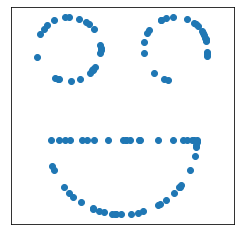

In [5]:
plt.figure(figsize=(4,4))
plt.scatter(*zip(*X))
plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.show()

We generate ten copies of this base shape, and apply random translations, dilations, and rotations.  

Note that the input to `GPA` is a $k \times n \times d$ `numpy` array, where:
- $k$ is the number of samples to align
- $n$ is the number of points in each samples
- $d$ is the dimension of the ambient space containing each sample

In [6]:
k = 10
n, d = X.shape

rng = np.random.default_rng(RANDOM_SEED)

# c = np.zeros(shape=(k,2))
c = rng.uniform(-5, 5, size=(k, 2))

# s = np.ones(shape=k)
s = rng.uniform(0.5, 2, size=k)

# q = np.stack([np.eye(2) for _ in range(k)])
t = 2 * np.pi * rng.uniform(size=k)
q = np.vstack([np.cos(t), -np.sin(t), np.sin(t), np.cos(t)]).T.reshape(k,2,2)

Y = c[:, np.newaxis, :] + s[:, np.newaxis, np.newaxis] * (X + rng.normal(scale=0.0, size=(k,n,d))) @ q

Here is a picture of our dataset, colored by sample.  The goal is to find the transformations that align each sample back to something like the base shape.

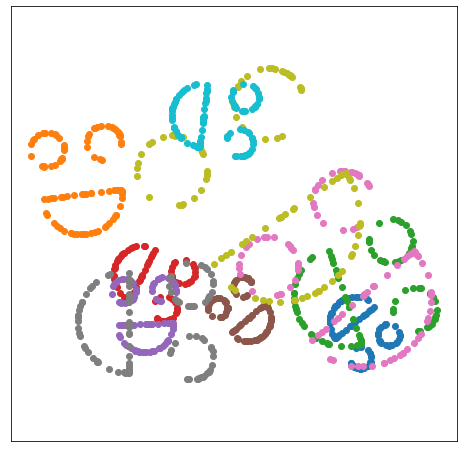

In [7]:
plt.figure(figsize=(8,8))
for i in range(len(Y)):
    plt.scatter(*zip(*Y[i]))

plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.show()

## Generalized Procrustes Alignment

### Basic usage
We demonstrate a basic application of our algorithm for the generalized Procrustes problem.  Note that we have to explicitly set `scaling=True` to allow dilations as possible transformations, since they are not isometries.

In [8]:
gpa = GPA(max_iter=1000, centering=True, scaling=True, verbose=True)

In [9]:
%%time
Y_fit = gpa.fit_transform(Y)

iteration 1: loss = 4.227314
iteration 2: loss = 0.000000
iteration 3: loss = 0.000000
CPU times: user 15.5 ms, sys: 3.02 ms, total: 18.5 ms
Wall time: 6.23 ms


Here we show the results.  On the left, we have an overlay of the ten samples after alignment, as returned by `GPA.fit_transform`.  On the right, we have the geometric centroid of the aligned samples, stored in `GPA.Z`.  Looks pretty good!

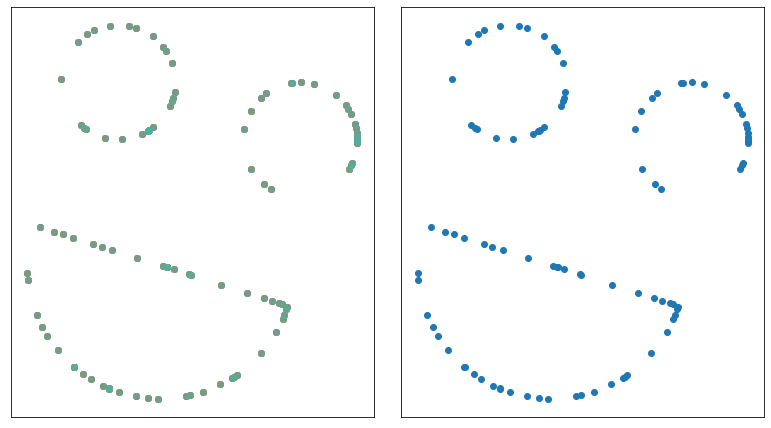

In [10]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11,6), sharex=True, sharey=True)
for i in range(len(Y_fit)):
    ax0.scatter(*zip(*Y_fit[i]), alpha=0.3)
ax1.scatter(*zip(*gpa.Z))

ax0.set_aspect('equal')
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()
plt.show()

For finetuning, the optimal transformations found by the algorithm can be accessed via:
- `GPA.c` for the translations $c$
- `GPA.s` for the dilation factor $s$
- `GPA.q` for the rotations and reflection, represented by the orthogonal matrix $Q$.

These are defined so that the transformation is given by $X \mapsto c + s X Q$.  For more details, see the attached document detailing the alternating minimization algorithm.

These optimal transformations are given in a stacked array.  The first dimension is the sample index.

As an example, we show the figure with each sample shape optimally rotated, but not translated or scaled.  

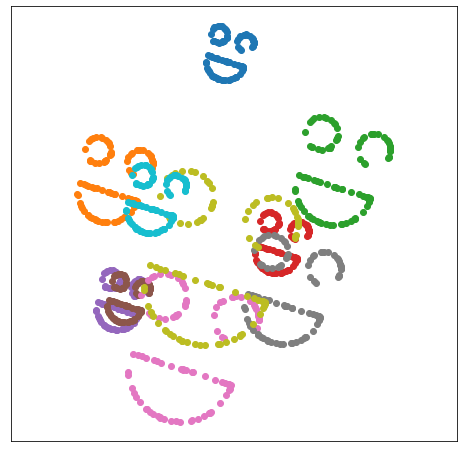

In [11]:
plt.figure(figsize=(8,8))
for i in range(len(Y)):
    plt.scatter(*zip(*(Y[i] @ gpa.q[i])))

plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.show()

## Missing data
One strength of the formulation of the Procrustes problem is its ability to handle missing values.  Here, we create a masked copy of our dataset with 500 random entries (25% of the data) blanked out, and perform the alignment again.

In [12]:
Y_masked = Y.copy()
for i, j in rng.choice(list(np.ndindex(k,n)), 500):
    Y_masked[i,j,:] = np.nan

In [13]:
gpa = GPA(max_iter=1000, centering=True, scaling=True, verbose=True)

In [14]:
%%time
Y_masked_fit = gpa.fit_transform(Y_masked)

iteration 1: loss = 2.966489
iteration 2: loss = 0.723017
iteration 3: loss = 0.162710
iteration 4: loss = 0.053289
iteration 5: loss = 0.010202
iteration 6: loss = 0.003880
iteration 7: loss = 0.000946
iteration 8: loss = 0.000322
iteration 9: loss = 0.000118
iteration 10: loss = 0.000018
iteration 11: loss = 0.000012
iteration 12: loss = 0.000003
iteration 13: loss = 0.000001
iteration 14: loss = 0.000000
iteration 15: loss = 0.000000
iteration 16: loss = 0.000000
iteration 17: loss = 0.000000
iteration 18: loss = 0.000000
iteration 19: loss = 0.000000
iteration 20: loss = 0.000000
iteration 21: loss = 0.000000
iteration 22: loss = 0.000000
CPU times: user 72.7 ms, sys: 8.61 ms, total: 81.3 ms
Wall time: 29.6 ms


Here are the results, in the same format as above.  Still not too shabby!

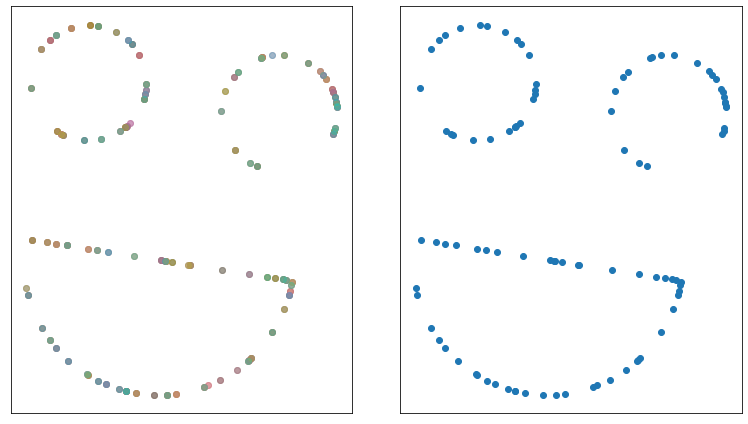

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11,6), sharex=True, sharey=True)
for i in range(len(Y_masked_fit)):
    ax0.scatter(*zip(*Y_masked_fit[i]), alpha=0.3)
ax1.scatter(*zip(*gpa.Z))

ax0.set_aspect('equal')
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()
plt.show()

## Geometric medians

Previously, the "average" was computed by taking the geometric centroid of the aligned samples.  Here, we compute the geometric *median* instead, using a modified Weiszfeld algorithm by Vardi and Zhang.  Note, this takes much longer to run.

In [16]:
gpa = GPA(max_iter=1000, p=1, centering=True, scaling=True, verbose=True)

In [17]:
%%time
Y_l1_fit = gpa.fit_transform(Y)

iteration 1: loss = 3.416753
iteration 2: loss = 0.000000
iteration 3: loss = 0.000000
CPU times: user 625 ms, sys: 11.1 ms, total: 636 ms
Wall time: 407 ms


/Users/jf3380/Documents/Procrustes/github/Procrustes.py:12: RuntimeWarning: divide by zero encountered in divide
  y = np.average(X, axis=0, weights=1/d)
/opt/anaconda3/envs/working/lib/python3.9/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in divide
  avg = np.multiply(a, wgt,


Here are the result again.  Since the alignment is so good, it makes essentially no difference whether we take the $\ell_2$-minimizer or the $\ell_1$-minimizer.

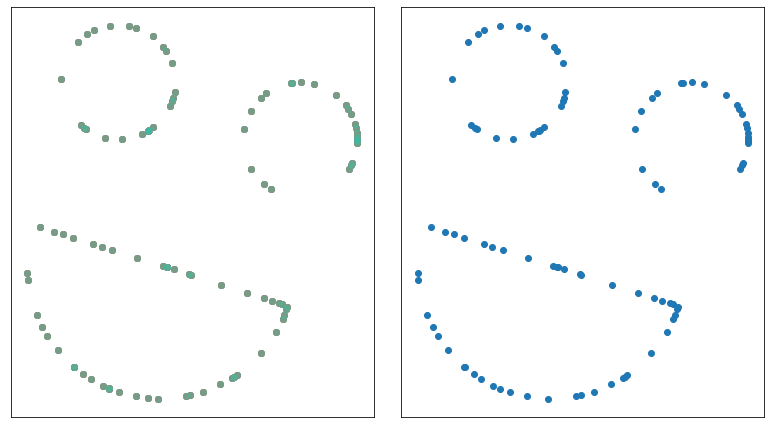

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11,6), sharex=True, sharey=True)
for i in range(len(Y_l1_fit)):
    ax0.scatter(*zip(*Y_l1_fit[i]), alpha=0.3)
ax1.scatter(*zip(*gpa.Z))

ax0.set_aspect('equal')
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()
plt.show()

## Noisy samples

We inject noise into our dataset and find the optimal Procrustes alignment.  Unlike in previous examples, the alignment cannot be perfect.  

In [19]:
rng = np.random.default_rng(RANDOM_SEED)

Y_noisy = Y + rng.normal(scale=0.1, size=Y.shape)

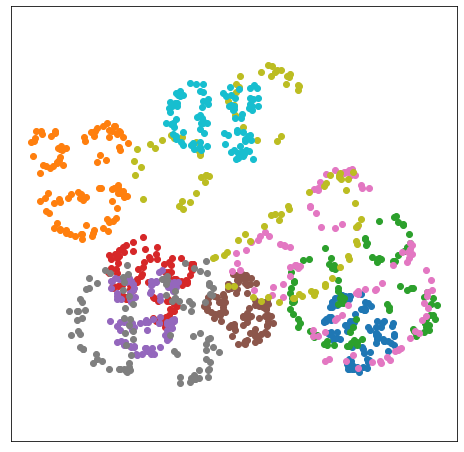

In [20]:
plt.figure(figsize=(8,8))
for i in range(len(Y_noisy)):
    plt.scatter(*zip(*Y_noisy[i]))

plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.show()

In [21]:
gpa = GPA(max_iter=1000, centering=True, scaling=True, verbose=True)

In [22]:
%%time
Y_noisy_fit = gpa.fit_transform(Y_noisy)

iteration 1: loss = 4.211720
iteration 2: loss = 0.112300
iteration 3: loss = 0.111751
iteration 4: loss = 0.111751
iteration 5: loss = 0.111751
CPU times: user 20 ms, sys: 2.98 ms, total: 22.9 ms
Wall time: 7.71 ms


On the left is the plot of all the aligned samples overlaid on top of each other.  The points do not perfectly coincide since we have added sample-specific noise.  On the right is the plot of the centroid of the aligned samples.

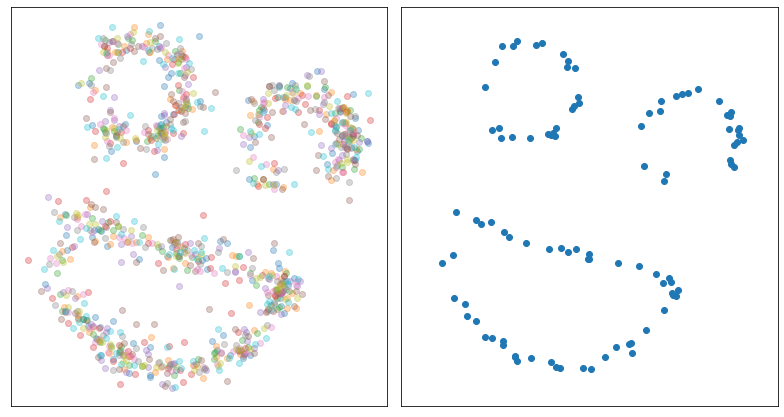

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11,6), sharex=True, sharey=True)
for i in range(len(Y_noisy_fit)):
    ax0.scatter(*zip(*Y_noisy_fit[i]), alpha=0.3)
ax1.scatter(*zip(*gpa.Z))

ax0.set_aspect('equal')
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_aspect('equal')
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()
plt.show()